In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from random import random
from numpy.random import randint

In [3]:
def transform_resnet_block(nrOfFilters, inputLayer):
    init = keras.initializers.RandomNormal(stddev=0.02)
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(inputLayer)
    # instead of Batchnormalization
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Activation('relu')(resnet)
    # TODO reflection padding
    resnet = keras.layers.Conv2D(nrOfFilters, (3,3), padding='same', kernel_initializer=init)(resnet)
    resnet = InstanceNormalization(axis=-1)(resnet)
    resnet = keras.layers.Concatenate()([resnet, inputLayer])
    return resnet



In [4]:
def general_generator(imageShape=(256,256,3), nrOfResnet=9):
    init = keras.initializers.RandomNormal(stddev=0.02)
    inputImage = keras.Input(shape=imageShape)
    # ----Encode ------
    generator = keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer=init)(inputImage)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    # ----Transform -----
    for _ in range(nrOfResnet):
        generator = transform_resnet_block(256, generator)
    # ----Decode ------
    generator = keras.layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    generator = keras.layers.Activation('relu')(generator)

    generator = keras.layers.Conv2D(3, (7,7), padding='same', kernel_initializer=init)(generator)
    generator = InstanceNormalization(axis=-1)(generator)
    outputImage = keras.layers.Activation('tanh')(generator)

    model = keras.Model(inputImage, outputImage)
    return model



In [5]:
# test creation of a generator
imageShape = (256,256, 3)
model = general_generator(imageShape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization[0][0]     
______________________________________________________________________________________________

In [6]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def general_discriminator(imageShape):
    init = RandomNormal(stddev=0.02)
    inputImage = Input(shape=imageShape)

    discriminator = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(inputImage)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    discriminator = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(discriminator)
    discriminator = InstanceNormalization(axis=-1)(discriminator)
    discriminator = LeakyReLU(alpha=0.2)(discriminator)

    output = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(discriminator)
    model = Model(inputImage, output)
    # TODO negative log likelihood (e.g. binary cross entropy).
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model


In [7]:
# test creation of a discriminator
imageShape = (256,256, 3)
model = general_discriminator(imageShape)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_24 (I (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 256)       5245

In [8]:
# Mean squared error, lambda 1
def adversarial_loss_model(generator, discriminator, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorOutput = generator(inputGenerator)
    outputDiscriminator = discriminator(generatorOutput)
    model = Model(inputGenerator, outputDiscriminator)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mse', loss_weights=[1], optimizer=opt)
    return model

# Mean absolute error, lambda 5
def identity_loss_model(generator, imageShape):
    inputIdentity = Input(shape=imageShape)
    outputIdentity = generator(inputIdentity)
    model = Model(inputIdentity, outputIdentity)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[5], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def forward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorG_output = generatorG(inputGenerator)
    generatorF_output = generatorF(generatorG_output)
    model = Model(inputGenerator, generatorF_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model

# Mean absolute error, lambda 10
def backward_cycle_loss_model(generatorG, generatorF, imageShape):
    inputGenerator = Input(shape=imageShape)
    generatorF_output = generatorF(inputGenerator)
    generatorG_output = generatorG(generatorF_output)
    model = Model(inputGenerator, generatorG_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='mae', loss_weights=[10], optimizer=opt)
    return model


test image shpae:  (337, 450, 3)


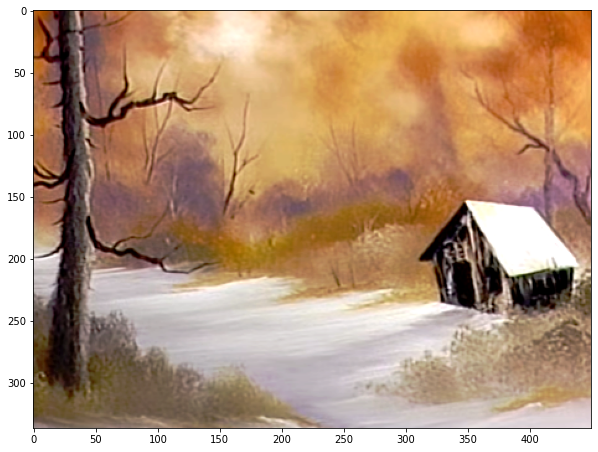

In [10]:
# sneak peak sample of a bob ross painting
from matplotlib import pyplot as plt
test_image = cv.imread('./data/bobross_paintings/Y/painting5.png')
print("test image shpae: ", test_image.shape)
test_image_bgr = cv.cvtColor(test_image, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(test_image_bgr)
plt.show()

In [11]:
tfds_cache_dir = os.path.join(os.getcwd(),'tfds_cache')
os.makedirs(tfds_cache_dir, exist_ok = True)

# Note: I have added this cell for you to run on your local computer to
# avoid any errors due to a misconfigured CUDA (and CuDNN) for your GPU.
# It will force tensorflow to use your CPU instead of your GPU.
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')

img_height = 256
img_width = 256
data_dir_bob = './data/bobross_paintings'

#saving some images as validation to try the model when finished
# (i.e. so that i dont have to go to google and find new images)
# TODO quickfix to use the whole dataset as one batch
train_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=393
)

val_ds_bob = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_bob,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=10
)


No GPU found
Found 403 files belonging to 1 classes.
Using 393 files for training.
Found 403 files belonging to 1 classes.
Using 10 files for validation.


In [12]:
img_height = 256
img_width = 256
data_dir_landscapes = './data/landscape_pictures'

#saving some images as validation to try the model when finished
# (i.e. so that i dont have to go to google and find new images)
# TODO quickfix to use the whole dataset as one 'batch'
train_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="training",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=4212
)

val_ds_landscapes = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_landscapes,
  validation_split=0.025,
  subset="validation",
  seed=1337,
  image_size=(img_height, img_width),
  batch_size=107
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_bob = train_ds_bob.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds_landscapes = train_ds_landscapes.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

Found 4319 files belonging to 1 classes.
Using 4212 files for training.
Found 4319 files belonging to 1 classes.
Using 107 files for validation.


'\nfirst_image_batch, labels_batch = next(landscapes_batches)\nfirst_image = first_image_batch[0]\nprint(first_image)\n'

In [13]:
# Only run this once to extract all the images and labels
paintings_ds = iter(train_ds_bob)
landscapes_ds = iter(train_ds_landscapes)
landscapes_val_ds = iter(val_ds_landscapes)
paintings, painting_labels = next(paintings_ds)
landscapes, landscape_labels = next(landscapes_ds)
landscapes_val, landscape_labels_val = next(landscapes_val_ds)
# Normalize the datasets to [0,1] to give the models an easier time training
paintings /= 255
landscapes /= 255


shape paitings before normalization (393, 256, 256, 3)
shape paintings:  (393, 256, 256, 3)
p len 393 p lab len 393
land len 4212 land lab len 4212
training steps :: 26300


In [15]:
# Make a batch of 16 st images and labels
# All real images should be labelled 1's
# TODO data generator that systematically works through each dataset instead of random sampling.
# This is a quick fix to train imbalanced datasets.
def create_random_batch(images, batchSize=16, discOutputShape=(None, 16, 16, 1)): 
    indexes = randint(0, len(images), batchSize)
    # retrieve selected images
    selectedImages = tf.gather(images, indexes)
    # genrate real class labels 1
    labels = tf.ones((batchSize, discOutputShape[1], discOutputShape[2], discOutputShape[3]), tf.int32)
    return selectedImages, labels

img shape (1, 256, 256, 3)


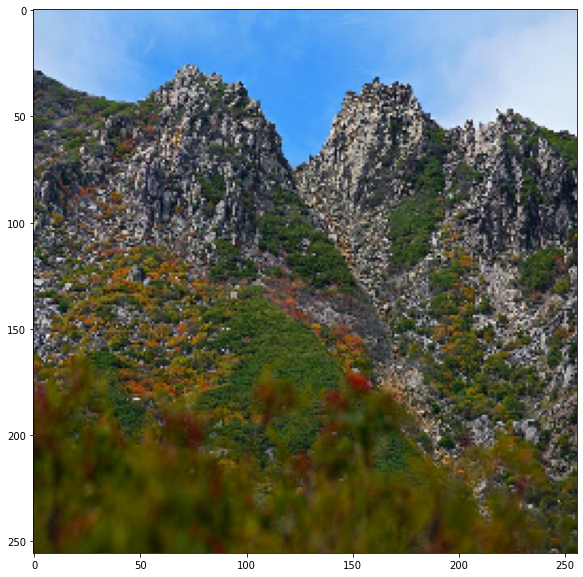

In [16]:
# print landscape real image sample
img, img_label = create_random_batch(landscapes_val, batchSize=1)
print("img shape", img.shape)
img /= 255.
real_image = (img + 1) / 2.0
real_image = tf.reshape(img, [256, 256, 3])
figure = plt.figure(figsize=(10,10))
plt.imshow(real_image)
plt.show()

In [17]:
# Imagepool based on: https://github.com/junyanz/CycleGAN/blob/master/util/image_pool.lua
# The paper defines an image pool of 50 generated images
# Returns only 1 generated image that the disciminator can calculate loss upon

def update_image_pool(pool, generatedImages, max_size=50):
	for image in generatedImages:
		if len(pool) < max_size:
			# append to pool
			pool.append(image)
			selectedImage = image
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selectedImage = image
		else:
			# replace an existing image and use the replaced image
			ix = randint(0, len(pool))
			selectedImage = pool[ix]
			pool[ix] = image
	return selectedImage

In [18]:
def plot_generate_to_painting(model, trainingStep):
    generated_images_dir = os.path.join(os.getcwd(),'generated_images')
    os.makedirs(generated_images_dir, exist_ok = True)
    img, img_label = create_random_batch(landscapes_val, batchSize=1)
    print("img shape", img.shape)

    img /= 255.
    img2 = (img + 1) / 2.0
    img2 = tf.reshape(img2, [1, 256, 256, 3])
    generated_test_image = model.predict(img2)
    real_image = (img + 1) / 2.0
    generated_test_image = generated_test_image.reshape((256,256,3))
    new_img_bgr = cv.cvtColor(generated_test_image, cv.COLOR_RGB2BGR)
    real_image = tf.reshape(real_image, [256, 256, 3])
    
    # Plot generated image
    plt.subplot(2, 1, 1)
    plt.axis('off')
    plt.imshow(new_img_bgr)
    # Plot real image
    plt.subplot(2, 1, 2)
    plt.axis('off')
    plt.imshow(real_image)
    
    filename = 'generated_images/generated_plot_' + str(trainingStep) + '.png'
    plt.savefig(filename)
    plt.close()


    
    

In [19]:
def save_models(modelG, modelF, trainingStep):
    generators_dir = os.path.join(os.getcwd(),'generators')
    os.makedirs(generators_dir, exist_ok = True)
    filename_model_G = 'generators/G_model' + str(trainingStep) + '.h5'
    modelG.save(filename_model_G)
    filename_model_F = 'generators/F_model' + str(trainingStep) + '.h5'
    modelF.save(filename_model_F)
    print('saved model G and F locally')

In [20]:
def train(Gx2y, Fy2x, Dy, Dx):
    nrOfTrainingEpochs = 100
    batchSize = 16
    discriminator_loss_size = 1
    poolG, poolF = list(), list()
    nrOfTrainingSteps = int(len(landscapes) / batchSize) * nrOfTrainingEpochs

    adversarial_loss_model_G = adversarial_loss_model(Gx2y, Dy, imageShape)
    identity_loss_model_G = identity_loss_model(Gx2y, imageShape)
    forward_cycle_loss_model_G = forward_cycle_loss_model(Gx2y, Fy2x, imageShape)
    backward_cycle_loss_model_G = backward_cycle_loss_model(Gx2y, Fy2x, imageShape)
    adversarial_loss_model_F = adversarial_loss_model(Fy2x, Dx, imageShape)
    identity_loss_model_F = identity_loss_model(Fy2x, imageShape)
    forward_cycle_loss_model_F = forward_cycle_loss_model(Fy2x, Gx2y, imageShape)
    backward_cycle_loss_model_F = backward_cycle_loss_model(Fy2x, Gx2y, imageShape)
    
    for i in range(nrOfTrainingSteps):
        # Create and gather batches, i.e. with standard settings 16 st images
        nextBatchRealPaintings, labelsBatchPaintings = create_random_batch(paintings)
        nextBatchRealLandscapes, labelsBatchLandscapes = create_random_batch(landscapes)
        # Pass real images thorugh both generators & create labels as 0 representing generated/fake images
        yPrimeArr = Gx2y.predict(nextBatchRealLandscapes)
        yPrimeLabels = tf.zeros((discriminator_loss_size, 16, 16, 1), tf.int32)
        yPrimeArr = update_image_pool(poolG, yPrimeArr)
        yPrimeArr = tf.reshape(yPrimeArr, [discriminator_loss_size, 256, 256, 3])
        xPrimeArr = Fy2x.predict(nextBatchRealPaintings)
        xPrimeLabels = tf.zeros((discriminator_loss_size, 16, 16, 1), tf.int32)
        xPrimeArr = update_image_pool(poolF, xPrimeArr)
        xPrimeArr = tf.reshape(xPrimeArr, [discriminator_loss_size, 256, 256, 3])
        # Adversarial losses 
        G_loss_adv = adversarial_loss_model_G.train_on_batch(nextBatchRealLandscapes, labelsBatchPaintings)
        F_loss_adv = adversarial_loss_model_F.train_on_batch(nextBatchRealPaintings, labelsBatchLandscapes)
        # Cycle losses
        G_loss_forward_cycle = forward_cycle_loss_model_G.train_on_batch(nextBatchRealLandscapes, nextBatchRealLandscapes)
        F_loss_forward_cycle = forward_cycle_loss_model_F.train_on_batch(nextBatchRealPaintings, nextBatchRealPaintings)
        G_loss_backward_cycle = backward_cycle_loss_model_G.train_on_batch(nextBatchRealPaintings, nextBatchRealPaintings)
        F_loss_backward_cycle = backward_cycle_loss_model_F.train_on_batch(nextBatchRealLandscapes, nextBatchRealLandscapes)
        # Identity losses
        G_loss_id = identity_loss_model_G.train_on_batch(nextBatchRealPaintings, nextBatchRealLandscapes)
        F_loss_id = identity_loss_model_F.train_on_batch(nextBatchRealLandscapes, nextBatchRealPaintings)
        # Discriminator losses
        Dy_loss_real = Dy.train_on_batch(nextBatchRealLandscapes, labelsBatchLandscapes)
        Dy_loss_fake = Dy.train_on_batch(yPrimeArr, yPrimeLabels)
        Dx_loss_real = Dx.train_on_batch(nextBatchRealPaintings, labelsBatchPaintings)
        Dx_loss_fake = Dx.train_on_batch(xPrimeArr, xPrimeLabels)
        if(i % 20 == 0):
            print("Batch performance in trainingstep: ", i, "metrics: adversarial ", G_loss_adv, " ", F_loss_adv, " cycle loss: ", G_loss_forward_cycle, " ", F_loss_forward_cycle, " ", G_loss_backward_cycle, " ", F_loss_backward_cycle)
            print("id loss: ", G_loss_id, " ", F_loss_id, "disc loss: ", Dy_loss_real, " ", Dy_loss_fake, " ", Dx_loss_real, " ", Dx_loss_fake)
        if(i % 500 == 0): 
            plot_generate_to_painting(Gx2y, i)
        if(i % 1000 == 0):
            save_models(Gx2y, Fy2x, i)

In [19]:
# ----- create models and train them ------
imageShape = (256,256, 3)
# generator G(x) -> y'
Gx2y = general_generator(imageShape)
# generator F(y') -> x'
Fy2x = general_generator(imageShape)
# discriminator D(y') -> real/fake painting?
Dy = general_discriminator(imageShape)
# discriminator D(x') -> real/fake landscape?
Dx = general_discriminator(imageShape)

train(Gx2y, Fy2x, Dy, Dx)


labels patch paintings shape::  (1, 16, 16, 1)
Batch performance in trainingstep:  0 metrics: adversarial  1.393575668334961   3.5452723503112793  cycle loss:  7.217275619506836   5.737739562988281   4.81868839263916   6.092623710632324
id loss:  3.267453193664551   2.0454702377319336 disc loss:  1.9532861709594727   3.845576286315918   1.2396658658981323   2.9040727615356445
img shape (1, 256, 256, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
saved model G and F locally


shape of new_img:  (256, 256, 3)


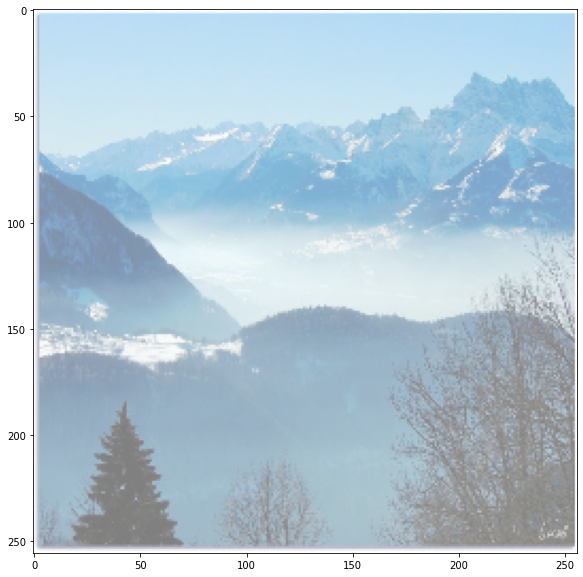

In [22]:
# Real image sample
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
new_img = (new_img + 1) / 2.0
print("shape of new_img: ", new_img.shape)
new_img_bgr = cv.cvtColor(new_img, cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(new_img_bgr)
plt.show()

In [109]:
# Predict with the local model Gx2y
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255.
print("shape of new_img: ", new_img.shape)
new_img = new_img.reshape((1, 256, 256, 3))
generated_test_image = Gx2y.predict(new_img)
new_img_bgr = cv.cvtColor(generated_test_image.reshape((256,256,3)), cv.COLOR_RGB2BGR)
figure = plt.figure(figsize=(10,10))
plt.imshow(new_img_bgr)
plt.show()

shape of new_img:  (256, 256, 3)


NameError: name 'Gx2y' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


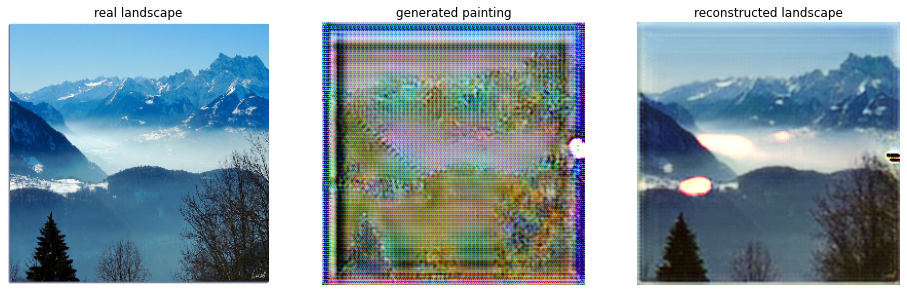

In [108]:
# load the saved models
# load the model with highest trainingstep number, it is probably the most accurate model
cust = {'InstanceNormalization': InstanceNormalization}
model_G_test = keras.models.load_model('./generators/G_model23500.h5', cust)
model_F_test = keras.models.load_model('./generators/F_model23500.h5', cust)
# testing predicting with the loaded model:
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255
new_img = cv.cvtColor(new_img, cv.COLOR_BGR2RGB)
real_landscape = new_img
new_img = new_img.reshape((1, 256, 256, 3))
# generating the generated image
generated_test_image = model_G_test.predict(new_img)
generated_test_image_reshaped = generated_test_image.reshape((256,256,3))
reconstructed_img = model_F_test.predict(generated_test_image)
reconstructed_img = reconstructed_img.reshape((256,256,3))

fig = plt.figure(figsize=(16,16))
# Plot real landscape
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(real_landscape)
plt.title('real landscape')
# Plot generated image
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(generated_test_image_reshaped)
plt.title('generated painting')
# Plot reconstructed
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(reconstructed_img)
plt.title('reconstructed landscape')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


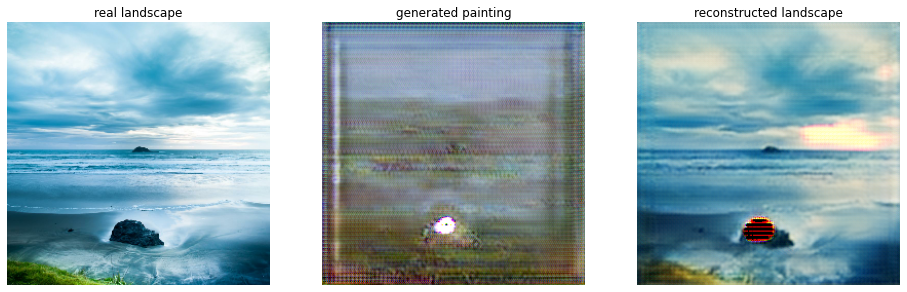

In [107]:
# load the models
# load the model with highest trainingstep number, it is probably the most trained model
cust = {'InstanceNormalization': InstanceNormalization}
model_G_test = keras.models.load_model('./generators/G_model20500.h5', cust)
model_F_test = keras.models.load_model('./generators/F_model20500.h5', cust)
# testing predicting with the loaded model:
img, img_label = create_random_batch(landscapes_val, batchSize=1)
new_img = img
new_img /= 255
real_landscape = tf.reshape(new_img, [256, 256, 3]) 
new_img = tf.reshape(new_img, [1, 256, 256, 3])   
# generating the generated image
generated_test_image = model_G_test.predict(new_img)
generated_test_image_reshaped = generated_test_image.reshape((256,256,3))
reconstructed_img = model_F_test.predict(generated_test_image)
reconstructed_img = reconstructed_img.reshape((256,256,3))

fig = plt.figure(figsize=(16,16))
# Plot real landscape
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(real_landscape)
plt.title('real landscape')
# Plot generated image
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(generated_test_image_reshaped)
plt.title('generated painting')
# Plot reconstructed
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(reconstructed_img)
plt.title('reconstructed landscape')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


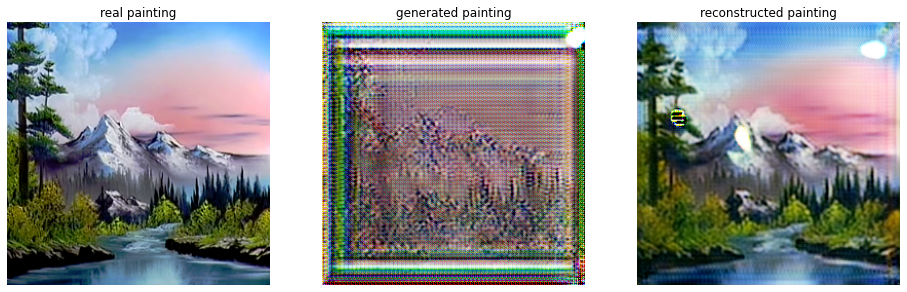

In [105]:
# generating to landscapes and back
# load the model with highest trainingstep number, it is probably the most trained model
cust = {'InstanceNormalization': InstanceNormalization}
model_G_test = keras.models.load_model('./generators/G_model23500.h5', cust)
model_F_test = keras.models.load_model('./generators/F_model23500.h5', cust)
# testing predicting with the loaded model:
img = cv.imread("./data/bobross_paintings/Y/painting15.png")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255
new_img = cv.cvtColor(new_img, cv.COLOR_BGR2RGB)
real_landscape = new_img
new_img = new_img.reshape((1, 256, 256, 3))
# generating the generated image
generated_test_image = model_F_test.predict(new_img)
generated_test_image_reshaped = generated_test_image.reshape((256,256,3))
reconstructed_img = model_G_test.predict(generated_test_image)
reconstructed_img = reconstructed_img.reshape((256,256,3))

fig = plt.figure(figsize=(16,16))
# Plot real painting
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(real_landscape)
plt.title('real painting')
# Plot generated image
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(generated_test_image_reshaped)
plt.title('generated landscape')
# Plot reconstructed
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(reconstructed_img)
plt.title('reconstructed painting')
plt.show()

shape of new_img:  (256, 256, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


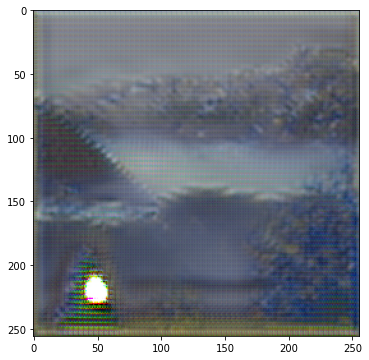

In [30]:
# load the saved models 
# load the model with highest trainingstep number, it is the most trained model
cust = {'InstanceNormalization': InstanceNormalization}
model_G_test = keras.models.load_model('./generators/G_model5500.h5', cust)
model_F_test = keras.models.load_model('./generators/F_model5500.h5', cust)
# testing predicting with the loaded model:
img = cv.imread("./data/landscape_pictures/X/00000000_(3).jpg")
new_img = cv.resize(img, (256, 256))
new_img = new_img.astype(np.float32)
new_img /= 255
print("shape of new_img: ", new_img.shape)
new_img = new_img.reshape((1, 256, 256, 3))
generated_test_image = model_G_test.predict(new_img)
generated_test_image = generated_test_image.reshape((256,256,3))
figure = plt.figure(figsize=(6,6))
plt.imshow(generated_test_image)
plt.show()